In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from keras import backend as K
import time
import numpy.random as r

raw_data = pd.read_csv('/Users/Denis/Documents/emnist-balanced-train.csv', delimiter=',')
train, validate = train_test_split(raw_data, test_size = 0.005)
x_train = train.values[:, 1:]
y_train = train.values[:,0]
x_validate = validate.values[:, 1:]
y_validate = validate.values[:,0]
img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], 784)
x_validate = x_validate.reshape(x_validate.shape[0], 784)
x_train = x_train.astype('float32')
x_validate = x_validate.astype('float32')
x_train /= 255
x_validate /= 255
num_classes = 47
y_train = keras.utils.to_categorical(y_train, num_classes)
y_validate = keras.utils.to_categorical(y_validate, num_classes)

Using TensorFlow backend.


In [4]:
nn_structure = [784, 100, 47]

def f(x):
    return 1 / (1 + np.exp(-x))

def f_deriv(x):
    return f(x) * (1 - f(x))

In [25]:
time1 = []
time2 = []
iterr = []
iterr2 = []

In [6]:
def setup_and_init_weights(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))*0.1
        b[l] = r.random_sample((nn_structure[l],))*0.1
    return W, b
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

In [7]:
def feed_forward(x, W, b):
    h = {1: x}
    z = {}
    for l in range(1, len(W) + 1):
        if l == 1:
            node_in = x
        else:
            node_in = h[l]
        z[l+1] = W[l].dot(node_in) + b[l] # z^(l+1) = W^(l)*h^(l) + b^(l)
        h[l+1] = f(z[l+1]) # h^(l) = f(z^(l))
    return h, z
 

In [8]:
def calculate_out_layer_delta(y, h_out, z_out):
    return -(y-h_out) * f_deriv(z_out)
def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [31]:
def train_nn(nn_structure, X, y, k, iter_num=50, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    m = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
    #avg_cost_func.append(7)
    #start = 7
    #start_time = time.time()
    #while avg_cost_func[-1]>k:
        if cnt%10 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(len(y)):
            delta = {}
            h, z = feed_forward(X[i, :], W, b)
            tri_w_perem, tri_b_perem = init_tri_values(nn_structure) 
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], h[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-h[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis]))
                    tri_w_perem[l] = np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis])) + np.random.randn(tri_w_perem[l].shape[0], tri_w_perem[l].shape[1])*0.005
                    tri_b[l] += delta[l+1]
                    tri_b_perem[l] = delta[l+1] + np.random.randn(tri_b_perem[l].shape[0])*0.005
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/m * tri_W[l])
            b[l] += -alpha * (1.0/m * tri_b[l])
        
        avg_cost = 1.0/m * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    #end_time = time.time()
    #time1.append(end_time - start_time)
    #iterr.append(start-k)
    return W, b, avg_cost_func


In [30]:
def train_nn_nature(nn_structure, X, y, iter_num=50, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    m = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%10 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        F_w = {} # Fisher 
        F_b = {}
        for l in range (1, len(nn_structure)):
            F_w[l] = np.zeros((nn_structure[l], nn_structure[l]))
            F_b[l] = np.zeros((nn_structure[l], nn_structure[l])) 
        for i in range(len(y)):
            delta = {}
            h, z = feed_forward(X[i, :], W, b)
            tri_w_perem, tri_b_perem = init_tri_values(nn_structure) 
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], h[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-h[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis]))
                    
                    tri_w_perem[l] = np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis])) + np.random.randn(tri_w_perem[l].shape[0], tri_w_perem[l].shape[1])*0.005
                    
                    tri_b[l] += delta[l+1]
                    
                    tri_b_perem[l] = delta[l+1] + np.random.randn(tri_b_perem[l].shape[0])*0.005
                    
                    F_w[l] += tri_w_perem[l]@tri_w_perem[l].T
                    tri_b_perem[l] = tri_b_perem[l].reshape(tri_b_perem[l].shape[0], 1)
                    F_b[l] += tri_b_perem[l]@tri_b_perem[l].T
                    
        F_w[l] = F_w[l]/m
        F_b[l] = F_b[l]/m
        for l in range(len(nn_structure) - 1, 0, -1):
            #W[l] += -alpha * (1.0/m * tri_W[l])
            #b[l] += -alpha * (1.0/m * tri_b[l])
            W[l] += -alpha*np.linalg.inv(F_w[l])@tri_W[l]
            b[l] += -alpha*np.linalg.inv(F_b[l])@tri_b[l]
        avg_cost = 1.0/m * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func

In [24]:
W, b, avg_cost_func1 = train_nn(nn_structure, x_validate, y_validate)
W, b, avg_cost_func2 = train_nn_nature(nn_structure, x_validate, y_validate)

Starting gradient descent for 50 iterations
Iteration 0 of 50


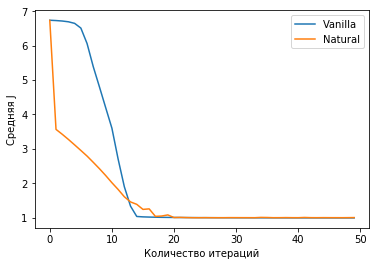

0.9911401017759002
1.0010774629444485


In [19]:
plt.plot(avg_cost_func1, label = 'Vanilla')
plt.plot(avg_cost_func2, label = 'Natural')
plt.ylabel('Средняя J')
plt.xlabel('Количество итераций')
plt.legend()
plt.show()
print(avg_cost_func1[-1])
print(avg_cost_func2[-1])
#plt.savefig('met_neu.pdf')

In [263]:
y_pred = predict_y(W, b, x_validate, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y, y_pred) * 100))

Prediction accuracy is 1.2411347517730498%


C:\Users\Denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [166]:
def predict_y(W, b, X, n_layers):
    m = X.shape[0]
    y = np.zeros((m,))
    for i in range(m):
        h, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(h[n_layers])
    return y